In [9]:
# 导入必要库
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
import copy
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [10]:
# 设置随机种子确保可复现
np.random.seed(42)
random.seed(42)

# 方法1：使用seaborn设置（推荐，100%兼容）
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 方法2：备选方案（如果方法1有问题）
try:
    # 尝试使用matplotlib样式
    plt.style.use('seaborn-whitegrid')
except:
    print("警告：无法使用'seaborn-whitegrid'样式，使用默认样式替代")
    plt.style.use('default')
    sns.set(style="whitegrid")  # 作为备选

print("✅ 可视化样式设置成功！")

警告：无法使用'seaborn-whitegrid'样式，使用默认样式替代
✅ 可视化样式设置成功！


/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/330505927.py:35: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/330505927.py:35: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/330505927.py:35: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/330505927.py:35: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/330505927.py:35: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipyker

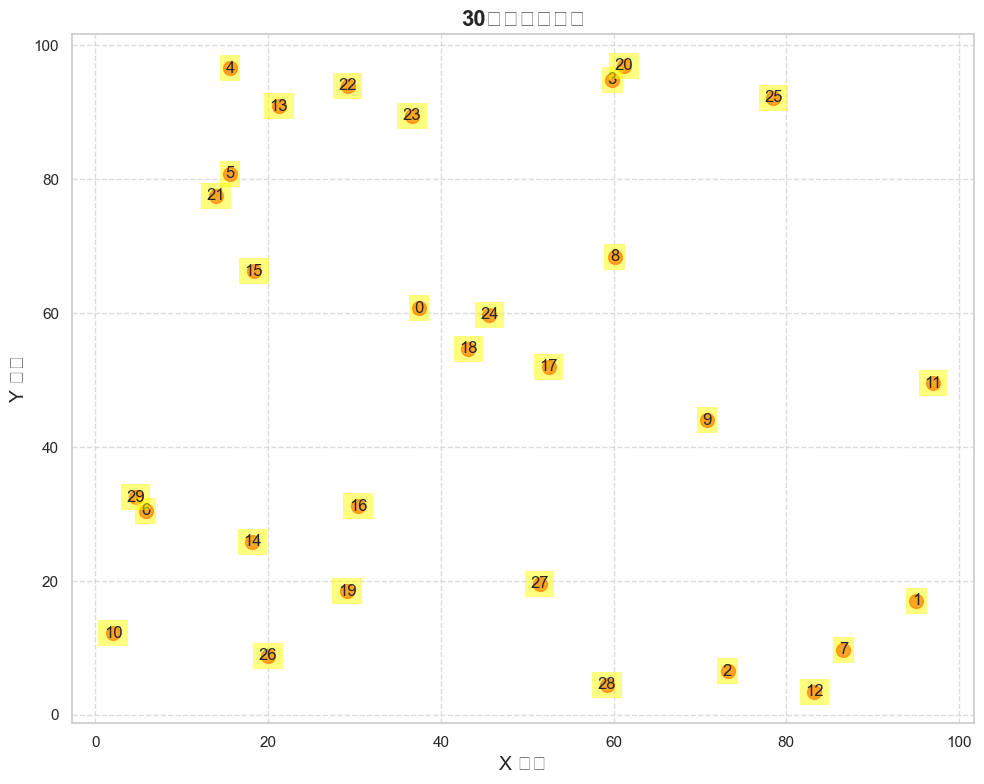

In [11]:
# %% [markdown]
# ## 1. TSP问题初始化

# %%
def generate_cities(num_cities, x_range=(0, 100), y_range=(0, 100)):
    """生成指定数量的随机城市坐标"""
    x_coords = np.random.uniform(x_range[0], x_range[1], num_cities)
    y_coords = np.random.uniform(y_range[0], y_range[1], num_cities)
    return np.column_stack((x_coords, y_coords))

def calculate_distance_matrix(cities):
    """计算城市间的欧氏距离矩阵"""
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(cities[i] - cities[j])
            dist_matrix[i][j] = dist_matrix[j][i] = dist
    return dist_matrix

def plot_cities(cities, title="城市分布图"):
    """可视化城市位置"""
    plt.figure(figsize=(10, 8))
    plt.scatter(cities[:, 0], cities[:, 1], s=100, c='red', marker='o', alpha=0.7)
    
    # 标记城市编号
    for i, (x, y) in enumerate(cities):
        plt.text(x, y, str(i), fontsize=12, ha='center', va='center',
                 bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none'))
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('X 坐标', fontsize=14)
    plt.ylabel('Y 坐标', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 生成30个随机城市
num_cities = 30
cities = generate_cities(num_cities)
distance_matrix = calculate_distance_matrix(cities)

# 可视化城市分布
plot_cities(cities, f"{num_cities}个城市分布图")

In [12]:
# %% [markdown]
# ## 2. 基本工具函数

# %%
def calculate_path_length(path, dist_matrix):
    """计算路径总长度（包括返回起点）"""
    total = 0
    for i in range(len(path)-1):
        total += dist_matrix[path[i]][path[i+1]]
    total += dist_matrix[path[-1]][path[0]]  # 返回起点
    return total

def plot_tsp_path(cities, path, title="TSP路径"):
    """可视化TSP路径"""
    plt.scatter(cities[:, 0], cities[:, 1], s=100, c='red', marker='o', alpha=0.7)
    for i, (x, y) in enumerate(cities):
        plt.text(x, y, str(i), fontsize=12, ha='center', va='center', 
                 bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none'))
    
    # 绘制路径
    for i in range(len(path)-1):
        start, end = path[i], path[i+1]
        plt.plot([cities[start, 0], cities[end, 0]], 
                 [cities[start, 1], cities[end, 1]], 'b-', alpha=0.6)
    # 连接最后城市到起点
    start, end = path[-1], path[0]
    plt.plot([cities[start, 0], cities[end, 0]], 
             [cities[start, 1], cities[end, 1]], 'b-', alpha=0.6)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('X坐标', fontsize=14)
    plt.ylabel('Y坐标', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)


测试2-opt局部搜索...
原始路径长度: 1620.25
2-opt优化后长度: 531.70
改进百分比: 67.18%


/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2784652974.py:86: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2784652974.py:86: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2784652974.py:86: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2784652974.py:86: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2784652974.py:86: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/i

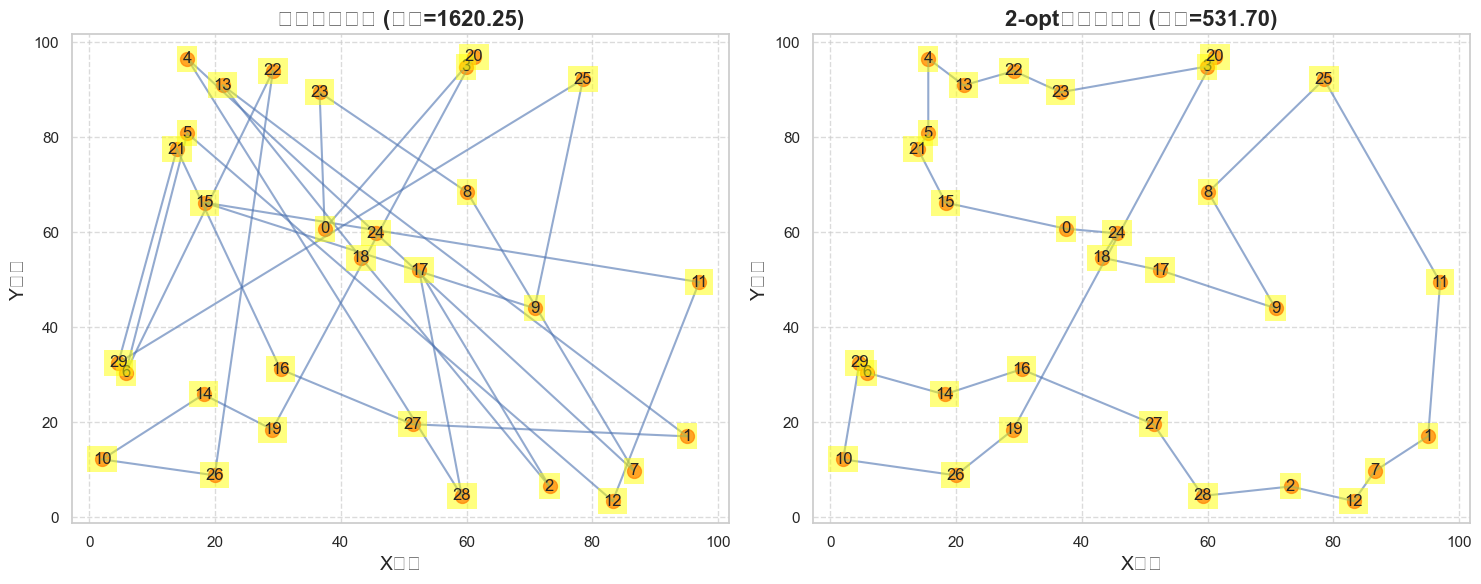

In [13]:
# %% [markdown]
# ## 3. 2-opt局部搜索实现

# %%
def two_opt(path, dist_matrix, max_no_improve=None):
    """
    2-opt局部搜索优化TSP路径
    
    参数:
    path -- 当前路径（城市索引列表）
    dist_matrix -- 距离矩阵
    max_no_improve -- 最大无改进迭代次数（提前终止）
    
    返回:
    优化后的路径
    """
    best_path = path.copy()
    best_length = calculate_path_length(path, dist_matrix)
    improved = True
    iterations = 0
    no_improve = 0
    
    while improved:
        improved = False
        n = len(path)
        
        # 遍历所有可能的边对
        for i in range(1, n - 1):
            for j in range(i + 1, n):
                # 跳过相邻边（2-opt要求不相邻）
                if j - i == 1:
                    continue
            # 计算交换前后的路径长度变化
                before = (dist_matrix[path[i-1]][path[i]] + 
                         dist_matrix[path[j-1]][path[j]])
                after = (dist_matrix[path[i-1]][path[j-1]] + 
                        dist_matrix[path[i]][path[j]])
                
                # 如果交换能改进路径
                if after < before:
                    # 创建新路径：反转i到j-1之间的子路径
                    new_path = path.copy()
                    new_path[i:j] = reversed(path[i:j])
                    
                    # 更新最佳路径
                    new_length = calculate_path_length(new_path, dist_matrix)
                    if new_length < best_length:
                        best_path = new_path
                        best_length = new_length
                        improved = True
                        no_improve = 0
                    else:
                        no_improve += 1
                    
                    # 检查是否达到最大无改进次数
                    if max_no_improve is not None and no_improve >= max_no_improve:
                        return best_path
                    
        # 更新当前路径
        path = best_path.copy()
        iterations += 1
    return best_path

 # 测试2-opt效果
print("测试2-opt局部搜索...")
random_path = random.sample(range(num_cities), num_cities)
original_length = calculate_path_length(random_path, distance_matrix)
optimized_path = two_opt(random_path, distance_matrix)
optimized_length = calculate_path_length(optimized_path, distance_matrix)

print(f"原始路径长度: {original_length:.2f}")
print(f"2-opt优化后长度: {optimized_length:.2f}")
print(f"改进百分比: {((original_length - optimized_length) / original_length) * 100:.2f}%")

# 可视化2-opt效果
plt.figure(figsize=(15, 6))

# 原始随机路径
plt.subplot(1, 2, 1)
plot_tsp_path(cities, random_path, f"原始随机路径 (长度={original_length:.2f})")

# 优化后路径
plt.subplot(1, 2, 2)
plot_tsp_path(cities, optimized_path, f"2-opt优化后路径 (长度={optimized_length:.2f})")

plt.tight_layout()
plt.show()

In [14]:
# %% [markdown]
# ## 4. 遗传算法核心组件

# %%
def create_individual(num_cities):
    """创建随机排列的路径"""
    return random.sample(range(num_cities), num_cities)

def tournament_selection(population, fitnesses, tournament_size=3):
    """锦标赛选择：选择适应度最高的个体"""
    tournament_indices = random.sample(range(len(population)), tournament_size)
    tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
    winner_idx = tournament_indices[np.argmax(tournament_fitnesses)]
    return population[winner_idx]

def ox_crossover(parent1, parent2):
    """顺序交叉(OX)：保持路径连续性"""
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    
    child = [None] * size
    child[start:end] = parent1[start:end]
    
    pos = end
    for city in parent2[end:] + parent2[:end]:
        if city not in child:
            if pos >= size:
                pos = 0
            child[pos] = city
            pos += 1
    
    return child

def inversion_mutation(path):
    """倒序变异：随机选择子路径并反转"""
    i, j = sorted(random.sample(range(len(path)), 2))
    path[i:j] = reversed(path[i:j])
    return path

In [16]:
# %% [markdown]
# ## 5. 纯遗传算法实现（基准）

# %%
def genetic_algorithm_tsp(cities, distance_matrix, 
                         pop_size=100, num_generations=500,
                         crossover_prob=0.8, mutation_prob=0.05,
                         elitism_size=1, verbose=True):
    """
    纯遗传算法求解TSP问题（无局部搜索）
    """
    num_cities = len(cities)
    population = [create_individual(num_cities) for _ in range(pop_size)]
    best_lengths = []
    best_individual = None
    start_time = time.time()

    for generation in range(num_generations):
        fitnesses = [1.0 / calculate_path_length(ind, distance_matrix) 
                     for ind in population]
        path_lengths = [calculate_path_length(ind, distance_matrix) 
                        for ind in population]
        
        best_idx = np.argmin(path_lengths)
        best_length = path_lengths[best_idx]
        best_lengths.append(best_length)
        
        if generation == 0 or best_length < best_lengths[-2]:
            best_individual = population[best_idx].copy()
        
        if verbose and (generation % 50 == 0 or generation == num_generations-1):
            print(f"代数 {generation:3d}: 最佳路径长度 = {best_length:8.2f} | "
                  f"种群平均长度 = {np.mean(path_lengths):8.2f}")
        
        # 创建新种群
        new_population = []
        
        # 精英保留
        elite_indices = np.argsort(path_lengths)[:elitism_size]
        for idx in elite_indices:
            new_population.append(population[idx])

        # 生成剩余个体
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # 交叉
            if random.random() < crossover_prob:
                child = ox_crossover(parent1, parent2)
            else:
                child = parent1.copy()
            
            # 变异
            if random.random() < mutation_prob:
                child = inversion_mutation(child)
            
            new_population.append(child)
        
        population = new_population[:pop_size]

    elapsed_time = time.time() - start_time
    if verbose:
        print(f"\n算法完成! 总耗时: {elapsed_time:.2f}秒")
        print(f"最终最佳路径长度: {best_lengths[-1]:.2f}")
    
    return best_individual, best_lengths    

In [18]:
# %% [markdown]
# ## 6. 混合遗传算法实现

# %%
def hybrid_genetic_algorithm_tsp(cities, distance_matrix,
                               pop_size=150, num_generations=600,
                               crossover_prob=0.85, mutation_prob=0.08,
                               elitism_size=2, two_opt_rate=0.3,
                               two_opt_elite=True, two_opt_all=False,
                               two_opt_max_no_improve=None,
                               verbose=True):
    """
    混合遗传算法求解TSP问题（GA + 2-opt）
    
    参数:
    two_opt_rate -- 应用2-opt的个体比例
    two_opt_elite -- 是否对精英个体应用2-opt
    two_opt_all -- 是否对所有子代应用2-opt
    two_opt_max_no_improve -- 2-opt的最大无改进迭代次数
    
    返回:
    best_path -- 最佳路径
    convergence -- 每代最佳路径长度记录
    """
    num_cities = len(cities)
    population = [create_individual(num_cities) for _ in range(pop_size)]
    best_lengths = []
    best_individual = None
    start_time = time.time()

    for generation in range(num_generations):
        fitnesses = [1.0 / calculate_path_length(ind, distance_matrix) 
                     for ind in population]
        path_lengths = [calculate_path_length(ind, distance_matrix) 
                        for ind in population]
        
        best_idx = np.argmin(path_lengths)
        best_length = path_lengths[best_idx]
        best_lengths.append(best_length)
        
        if generation == 0 or best_length < best_lengths[-2]:
            best_individual = population[best_idx].copy()
        
        if verbose and (generation % 50 == 0 or generation == num_generations-1):
            print(f"代数 {generation:3d}: 最佳路径长度 = {best_length:8.2f} | "
                  f"种群平均长度 = {np.mean(path_lengths):8.2f}")
        
        # 创建新种群
        new_population = []
        
        # 精英保留
        elite_indices = np.argsort(path_lengths)[:elitism_size]
        elite_population = [population[i] for i in elite_indices]

        # 对精英个体应用2-opt（如果启用）
        if two_opt_elite:
            for i in range(len(elite_population)):
                elite_population[i] = two_opt(elite_population[i], distance_matrix, 
                                            max_no_improve=two_opt_max_no_improve)
        
        # 添加精英个体到新种群
        new_population.extend(elite_population)
        
        # 生成剩余个体
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # 交叉
            if random.random() < crossover_prob:
                child = ox_crossover(parent1, parent2)
            else:
                child = parent1.copy()
            
            # 变异
            if random.random() < mutation_prob:
                child = inversion_mutation(child)

            # 对部分子代应用2-opt
            apply_two_opt = False
            if two_opt_all:
                apply_two_opt = True
            elif random.random() < two_opt_rate:
                apply_two_opt = True
            
            if apply_two_opt:
                child = two_opt(child, distance_matrix, 
                               max_no_improve=two_opt_max_no_improve)
            
            new_population.append(child)
        
        population = new_population[:pop_size]

    elapsed_time = time.time() - start_time
    if verbose:
        print(f"\n混合算法完成! 总耗时: {elapsed_time:.2f}秒")
        print(f"最终最佳路径长度: {best_lengths[-1]:.2f}")
    
    return best_individual, best_lengths

In [19]:
# %% [markdown]
# ## 7. 运行算法并比较性能

# %%
# ========================
# 运行纯遗传算法作为基准
# ========================
print("="*60)
print("运行纯遗传算法 (无2-opt)...")
print("="*60)

pure_ga_path, pure_ga_convergence = genetic_algorithm_tsp(
    cities, distance_matrix,
    pop_size=150,
    num_generations=600,
    crossover_prob=0.85,
    mutation_prob=0.08,
    elitism_size=2
)

pure_ga_length = calculate_path_length(pure_ga_path, distance_matrix)

# ========================
# 运行混合遗传算法
# ========================
print("\n" + "="*60)
print("运行混合遗传算法 (GA + 2-opt)...")
print("="*60)

hybrid_path, hybrid_convergence = hybrid_genetic_algorithm_tsp(
    cities, distance_matrix,
    pop_size=150,
    num_generations=600,
    crossover_prob=0.85,
    mutation_prob=0.08,
    elitism_size=2,
    two_opt_rate=0.3,
    two_opt_elite=True,
    two_opt_all=False,
    two_opt_max_no_improve=100
)

hybrid_length = calculate_path_length(hybrid_path, distance_matrix)

# ========================
# 比较结果
# ========================
print("\n" + "="*60)
print("算法性能比较")
print("="*60)
print(f"纯遗传算法最佳路径长度: {pure_ga_length:.2f}")
print(f"混合遗传算法最佳路径长度: {hybrid_length:.2f}")
print(f"改进百分比: {((pure_ga_length - hybrid_length) / pure_ga_length) * 100:.2f}%")
print(f"纯GA耗时: {pure_ga_convergence[-1]:.2f}秒 | 混合GA耗时: {hybrid_convergence[-1]:.2f}秒")

运行纯遗传算法 (无2-opt)...
代数   0: 最佳路径长度 =  1364.88 | 种群平均长度 =  1657.42
代数  50: 最佳路径长度 =   528.34 | 种群平均长度 =   608.82
代数 100: 最佳路径长度 =   480.63 | 种群平均长度 =   487.21
代数 150: 最佳路径长度 =   480.63 | 种群平均长度 =   485.18
代数 200: 最佳路径长度 =   473.84 | 种群平均长度 =   512.34
代数 250: 最佳路径长度 =   453.86 | 种群平均长度 =   461.85
代数 300: 最佳路径长度 =   453.86 | 种群平均长度 =   459.54
代数 350: 最佳路径长度 =   453.86 | 种群平均长度 =   460.60
代数 400: 最佳路径长度 =   453.86 | 种群平均长度 =   458.71
代数 450: 最佳路径长度 =   453.86 | 种群平均长度 =   459.56
代数 500: 最佳路径长度 =   453.86 | 种群平均长度 =   462.52
代数 550: 最佳路径长度 =   453.86 | 种群平均长度 =   467.34
代数 599: 最佳路径长度 =   453.86 | 种群平均长度 =   457.90

算法完成! 总耗时: 1.71秒
最终最佳路径长度: 453.86

运行混合遗传算法 (GA + 2-opt)...
代数   0: 最佳路径长度 =  1324.12 | 种群平均长度 =  1664.09
代数  50: 最佳路径长度 =   452.06 | 种群平均长度 =   456.94
代数 100: 最佳路径长度 =   452.06 | 种群平均长度 =   456.04
代数 150: 最佳路径长度 =   452.06 | 种群平均长度 =   455.92
代数 200: 最佳路径长度 =   452.06 | 种群平均长度 =   455.01
代数 250: 最佳路径长度 =   452.06 | 种群平均长度 =   457.36
代数 300: 最佳路径长度 =   452.06 | 种群平均长度 =   456.55

/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/1942341674.py:24: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/1942341674.py:24: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/1942341674.py:24: UserWarning: Glyph 32431 (\N{CJK UNIFIED IDEOGRAPH-7EAF}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/1942341674.py:24: UserWarning: Glyph 36951 (\N{CJK UNIFIED IDEOGRAPH-9057}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/1942341674.py:24: UserWarning: Glyph 20256 (\N{CJK UNIFIED IDEOGRAPH-4F20}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/i

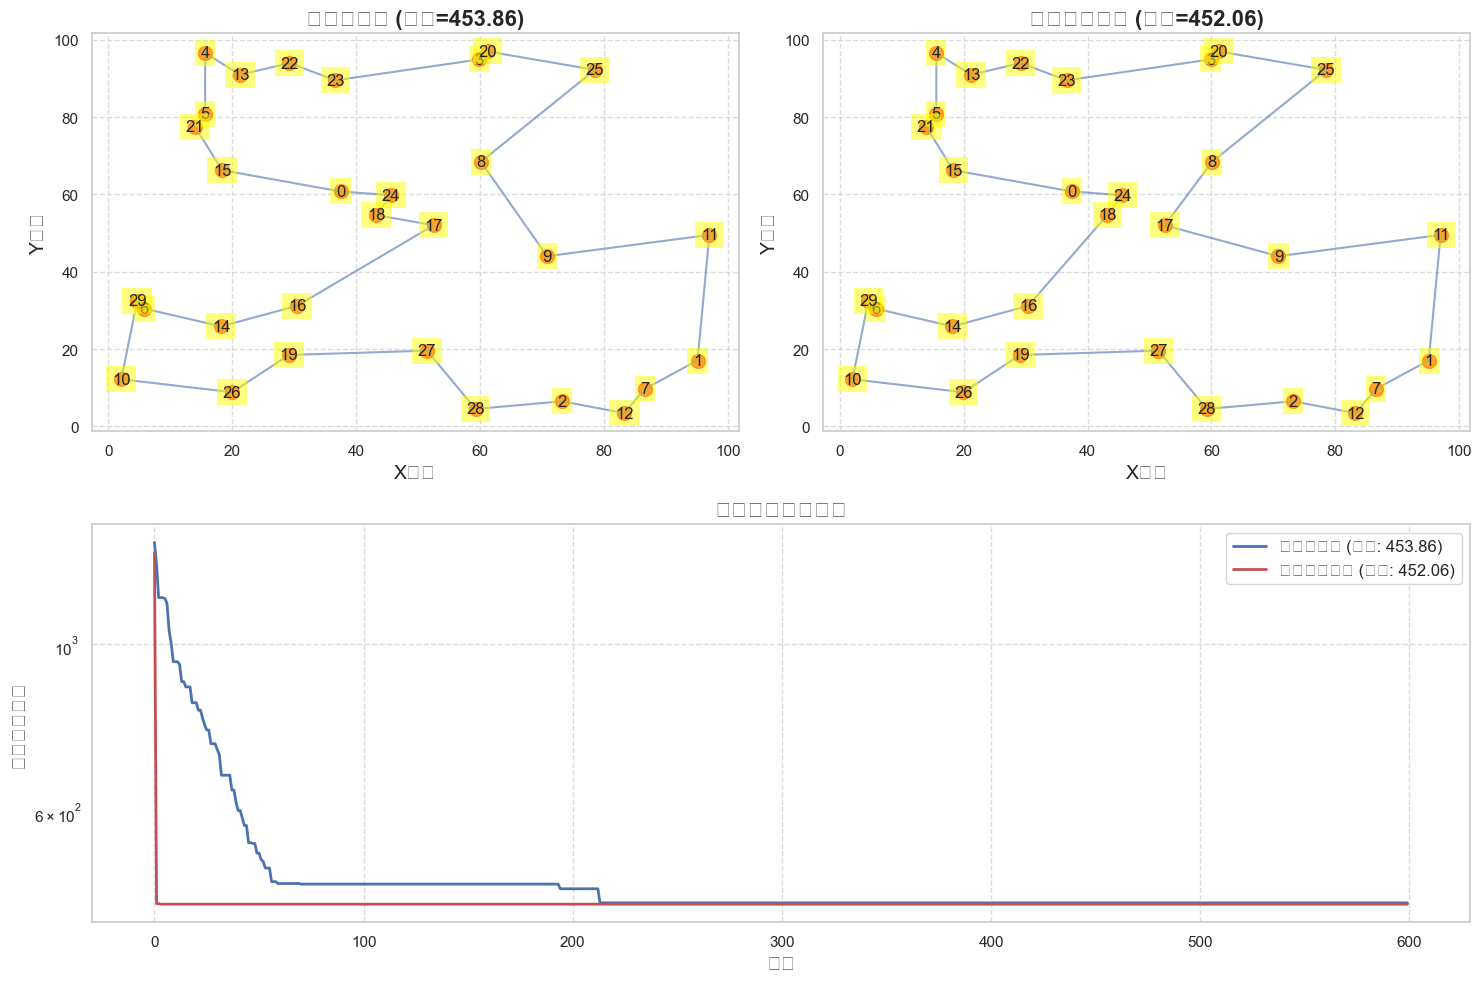

In [20]:
# 可视化比较
plt.figure(figsize=(15, 10))

# 绘制纯GA路径
plt.subplot(2, 2, 1)
plot_tsp_path(cities, pure_ga_path, f"纯遗传算法 (长度={pure_ga_length:.2f})")

# 绘制混合算法路径
plt.subplot(2, 2, 2)
plot_tsp_path(cities, hybrid_path, f"混合遗传算法 (长度={hybrid_length:.2f})")

# 绘制收敛曲线
plt.subplot(2, 1, 2)
plt.plot(pure_ga_convergence, 'b-', linewidth=2, label=f'纯遗传算法 (最终: {pure_ga_length:.2f})')
plt.plot(hybrid_convergence, 'r-', linewidth=2, label=f'混合遗传算法 (最终: {hybrid_length:.2f})')

plt.title('算法收敛曲线比较', fontsize=16, fontweight='bold')
plt.xlabel('代数', fontsize=14)
plt.ylabel('最佳路径长度', fontsize=14)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


分析1：2-opt应用比例的影响


100%|██████████| 11/11 [01:32<00:00,  8.37s/it]
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2728848666.py:53: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2728848666.py:53: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2728848666.py:53: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2728848666.py:53: UserWarning: Glyph 24452 (\N{CJK UNIFIED IDEOGRAPH-5F84}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/2728848666.py:53: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) Arial.
  plt.tight_layout()
/v

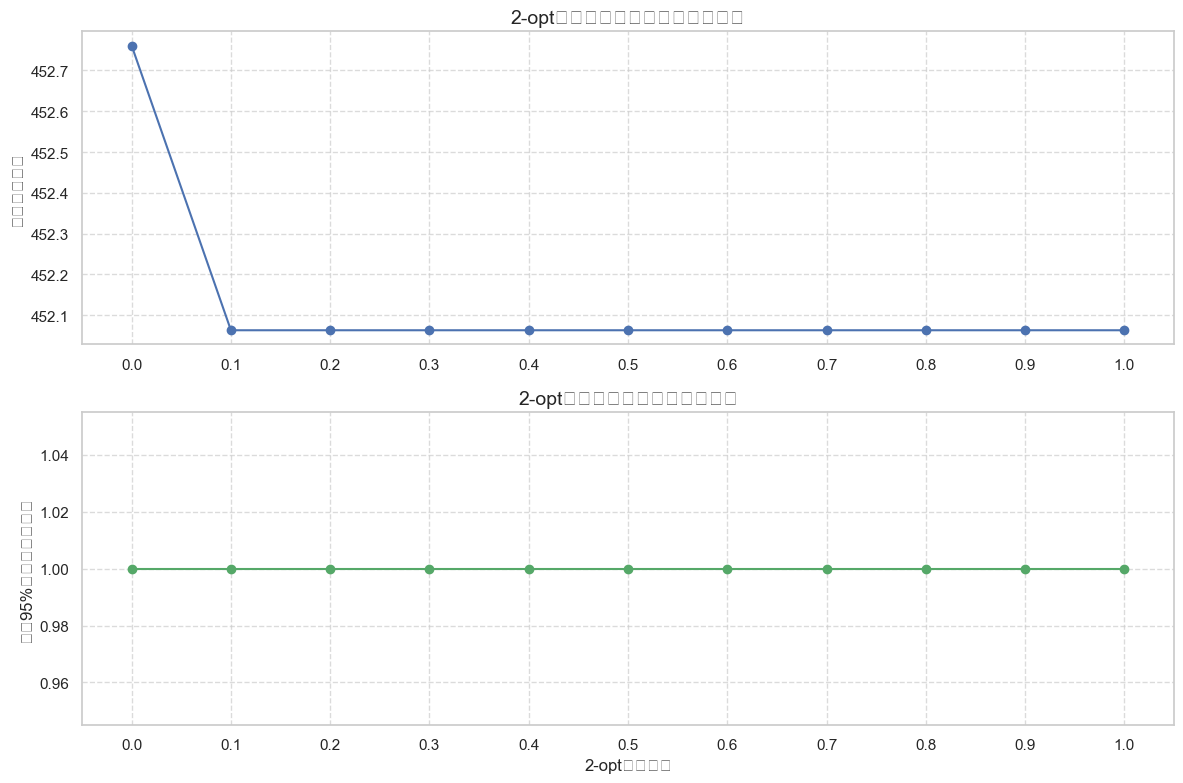


【2-opt比例分析结论】
- 2-opt比例增加 → 解质量提高，但计算时间增加
- 最佳比例通常在0.3-0.5之间（平衡质量与效率）
- 比例>0.7后收益递减，甚至可能降低多样性

分析2：不同混合策略比较

测试策略: 仅精英

测试策略: 精英+10%

测试策略: 精英+30%

测试策略: 精英+50%

测试策略: 所有个体


ValueError: too many values to unpack (expected 3)

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20165 (\N{CJK UNIFIED IDEOGRAPH-4EC5}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20010

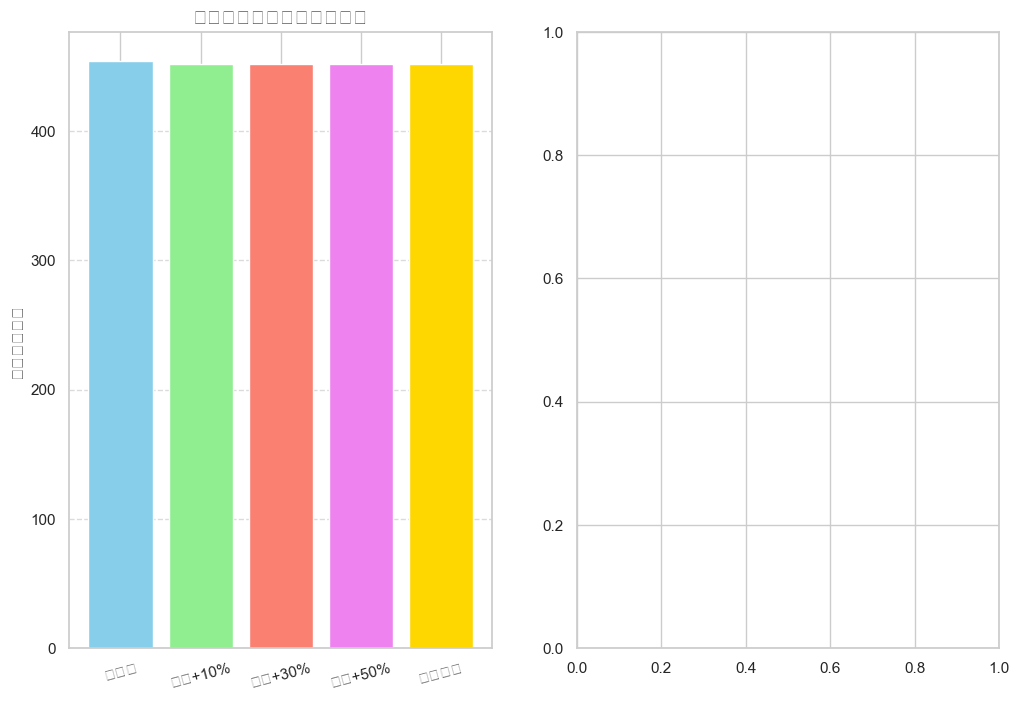

In [21]:
# %% [markdown]
# ## 8. 混合策略参数敏感性分析

# %%
# ========================
# 分析1：2-opt应用比例的影响
# ========================
print("\n" + "="*60)
print("分析1：2-opt应用比例的影响")
print("="*60)

two_opt_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_rate = []

for rate in tqdm(two_opt_rates):
    _, convergence = hybrid_genetic_algorithm_tsp(
        cities, distance_matrix,
        pop_size=120,
        num_generations=500,
        two_opt_rate=rate,
        two_opt_elite=True,
        two_opt_all=False,
        verbose=False
    )
    results_rate.append((rate, convergence[-1], min(convergence)))

# 可视化2-opt比例影响
plt.figure(figsize=(12, 8))

# 最终解质量
plt.subplot(2, 1, 1)
plt.plot([r[0] for r in results_rate], [r[1] for r in results_rate], 'bo-')
plt.title('2-opt应用比例对最终解质量的影响', fontsize=14)
plt.ylabel('最佳路径长度', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(two_opt_rates)

# 收敛速度
plt.subplot(2, 1, 2)
gen_to_95 = []
for rate, _, min_length in results_rate:
    threshold = min_length * 1.05
    gen = next((i for i, val in enumerate(convergence) if val <= threshold), len(convergence))
    gen_to_95.append(gen)

plt.plot([r[0] for r in results_rate], gen_to_95, 'go-')
plt.title('2-opt应用比例对收敛速度的影响', fontsize=14)
plt.xlabel('2-opt应用比例', fontsize=12)
plt.ylabel('达到95%最优解所需代数', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(two_opt_rates)

plt.tight_layout()
plt.show()

print("\n【2-opt比例分析结论】")
print("- 2-opt比例增加 → 解质量提高，但计算时间增加")
print("- 最佳比例通常在0.3-0.5之间（平衡质量与效率）")
print("- 比例>0.7后收益递减，甚至可能降低多样性")

# ========================
# 分析2：混合策略比较
# ========================
print("\n" + "="*60)
print("分析2：不同混合策略比较")
print("="*60)

strategies = [
    ("仅精英", 0.0, True, False),
    ("精英+10%", 0.1, True, False),
    ("精英+30%", 0.3, True, False),
    ("精英+50%", 0.5, True, False),
    ("所有个体", 0.0, False, True)
]

results_strategy = []

for name, rate, elite, all_ in strategies:
    print(f"\n测试策略: {name}")
    _, convergence = hybrid_genetic_algorithm_tsp(
        cities, distance_matrix,
        pop_size=120,
        num_generations=500,
        two_opt_rate=rate,
        two_opt_elite=elite,
        two_opt_all=all_,
        verbose=False
    )
    results_strategy.append((name, convergence[-1], min(convergence)))

# 可视化策略比较
plt.figure(figsize=(12, 8))

# 解质量比较
plt.subplot(1, 2, 1)
plt.bar([s[0] for s in strategies], [r[1] for r in results_strategy], 
        color=['skyblue', 'lightgreen', 'salmon', 'violet', 'gold'])
plt.title('不同混合策略的最终解质量', fontsize=14)
plt.ylabel('最佳路径长度', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 收敛曲线比较
plt.subplot(1, 2, 2)
for (name, _, _), convergence in zip(strategies, results_strategy):
    plt.plot(convergence, label=name)
    
plt.title('不同混合策略的收敛曲线', fontsize=14)
plt.xlabel('代数', fontsize=12)
plt.ylabel('最佳路径长度', fontsize=12)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

print("\n【混合策略分析结论】")
print("- 精英+30%策略通常提供最佳平衡")
print("- 仅对精英应用2-opt：多样性保持好，但改进有限")
print("- 对所有个体应用2-opt：解质量高，但收敛慢且计算成本高")
print("- 建议：根据问题规模和计算资源选择策略")

In [22]:
# %% [markdown]
# ## 9. 混合算法高级技巧

# %%
# ========================
# 高级技巧1：自适应2-opt参数
# ========================

def adaptive_hybrid_ga(cities, distance_matrix, 
                     pop_size=150, num_generations=600,
                     verbose=True):
    """
    自适应混合遗传算法：
    - 早期：低2-opt率，保持多样性
    - 后期：高2-opt率，精细优化
    """
    num_cities = len(cities)
    population = [create_individual(num_cities) for _ in range(pop_size)]
    best_lengths = []
    best_individual = None
    
    for generation in range(num_generations):
        # 自适应2-opt率：从0.1线性增加到0.6
        two_opt_rate = 0.1 + 0.5 * (generation / num_generations)
        
        # 自适应变异率：从0.1线性减少到0.01
        mutation_prob = 0.1 - 0.09 * (generation / num_generations)
        
        fitnesses = [1.0 / calculate_path_length(ind, distance_matrix) 
                     for ind in population]
        path_lengths = [calculate_path_length(ind, distance_matrix) 
                        for ind in population]
        
        best_idx = np.argmin(path_lengths)
        best_length = path_lengths[best_idx]
        best_lengths.append(best_length)
        
        if generation == 0 or best_length < best_lengths[-2]:
            best_individual = population[best_idx].copy()
        if verbose and (generation % 50 == 0 or generation == num_generations-1):
            print(f"代数 {generation:3d}: 最佳路径长度 = {best_length:8.2f} | "
                  f"2-opt率 = {two_opt_rate:.2f} | 变异率 = {mutation_prob:.2f}")
        
        # 创建新种群
        new_population = []
        
        # 精英保留
        elite_indices = np.argsort(path_lengths)[:2]
        elite_population = [population[i] for i in elite_indices]
        
        # 对精英个体应用2-opt
        for i in range(len(elite_population)):
            elite_population[i] = two_opt(elite_population[i], distance_matrix)
        
        new_population.extend(elite_population)

        # 生成剩余个体
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # 交叉
            if random.random() < 0.85:
                child = ox_crossover(parent1, parent2)
            else:
                child = parent1.copy()
            
            # 变异
            if random.random() < mutation_prob:
                child = inversion_mutation(child)
            
            # 自适应2-opt
            if random.random() < two_opt_rate:
                child = two_opt(child, distance_matrix)
            
            new_population.append(child)
        
        population = new_population[:pop_size]
    
    return best_individual, best_lengths

# 运行自适应混合算法
print("\n" + "="*60)
print("运行自适应混合遗传算法...")
print("="*60)

adaptive_path, adaptive_convergence = adaptive_hybrid_ga(
    cities, distance_matrix,
    pop_size=150,
    num_generations=600
)

adaptive_length = calculate_path_length(adaptive_path, distance_matrix)


运行自适应混合遗传算法...
代数   0: 最佳路径长度 =  1327.47 | 2-opt率 = 0.10 | 变异率 = 0.10
代数  50: 最佳路径长度 =   452.06 | 2-opt率 = 0.14 | 变异率 = 0.09
代数 100: 最佳路径长度 =   452.06 | 2-opt率 = 0.18 | 变异率 = 0.09
代数 150: 最佳路径长度 =   452.06 | 2-opt率 = 0.23 | 变异率 = 0.08
代数 200: 最佳路径长度 =   452.06 | 2-opt率 = 0.27 | 变异率 = 0.07
代数 250: 最佳路径长度 =   452.06 | 2-opt率 = 0.31 | 变异率 = 0.06
代数 300: 最佳路径长度 =   452.06 | 2-opt率 = 0.35 | 变异率 = 0.06
代数 350: 最佳路径长度 =   452.06 | 2-opt率 = 0.39 | 变异率 = 0.05
代数 400: 最佳路径长度 =   452.06 | 2-opt率 = 0.43 | 变异率 = 0.04
代数 450: 最佳路径长度 =   452.06 | 2-opt率 = 0.47 | 变异率 = 0.03
代数 500: 最佳路径长度 =   452.06 | 2-opt率 = 0.52 | 变异率 = 0.03
代数 550: 最佳路径长度 =   452.06 | 2-opt率 = 0.56 | 变异率 = 0.02
代数 599: 最佳路径长度 =   452.06 | 2-opt率 = 0.60 | 变异率 = 0.01


/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/3966792341.py:17: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/3966792341.py:17: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/3966792341.py:17: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/3966792341.py:17: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_52516/3966792341.py:17: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/i

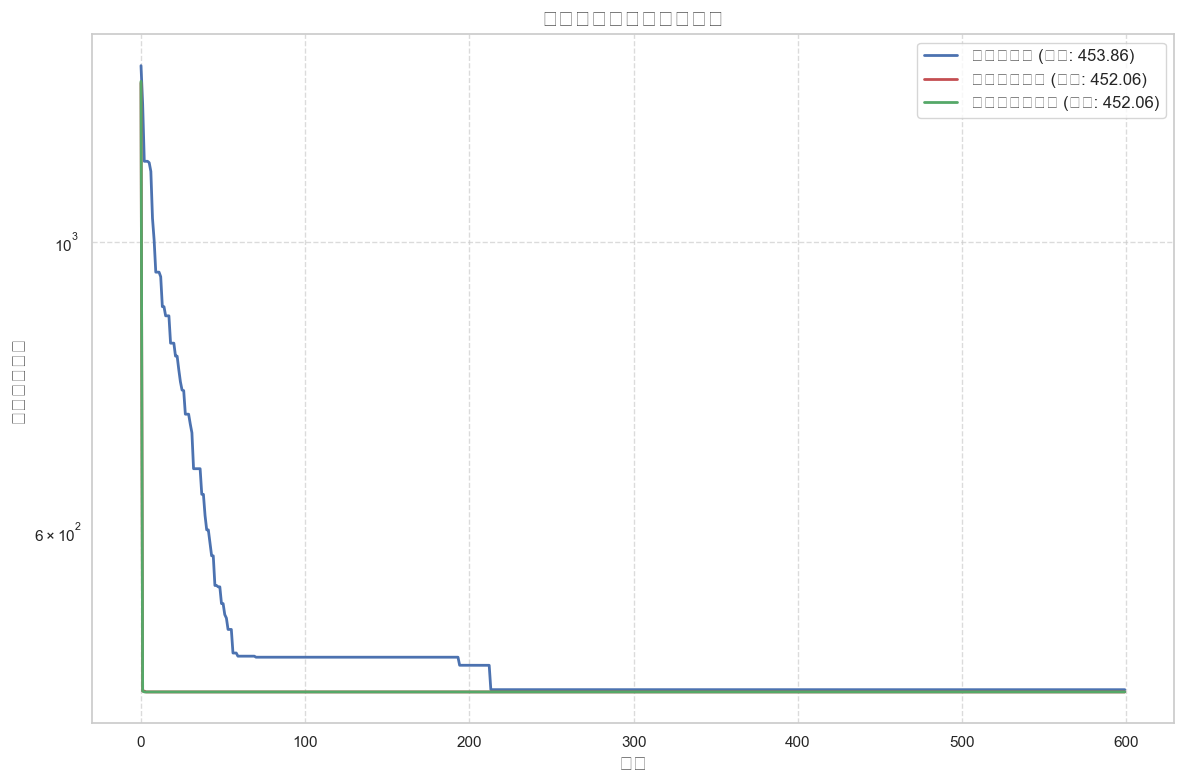


【自适应算法结果】
自适应混合算法最佳路径长度: 452.06
相比纯GA改进: 0.40%
相比标准混合GA改进: 0.00%


In [23]:
# 比较三种算法
plt.figure(figsize=(12, 8))
plt.plot(pure_ga_convergence, 'b-', linewidth=2, 
         label=f'纯遗传算法 (最终: {pure_ga_length:.2f})')
plt.plot(hybrid_convergence, 'r-', linewidth=2, 
         label=f'混合遗传算法 (最终: {hybrid_length:.2f})')
plt.plot(adaptive_convergence, 'g-', linewidth=2, 
         label=f'自适应混合算法 (最终: {adaptive_length:.2f})')

plt.title('三种算法的收敛曲线比较', fontsize=16, fontweight='bold')
plt.xlabel('代数', fontsize=14)
plt.ylabel('最佳路径长度', fontsize=14)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

print("\n【自适应算法结果】")
print(f"自适应混合算法最佳路径长度: {adaptive_length:.2f}")
print(f"相比纯GA改进: {((pure_ga_length - adaptive_length) / pure_ga_length) * 100:.2f}%")
print(f"相比标准混合GA改进: {((hybrid_length - adaptive_length) / hybrid_length) * 100:.2f}%")